# Screen Exercise
> Ruiyu Hu | rayhu@pm.me

In [1]:
# import the regular packages
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv('../data/screening_exercise_orders_v201810.csv')
df.head()

customer_id  gender                 date  value  predicted_gender
0         1000       0  2017-01-01 00:11:31  198.5                 1
1         1001       0  2017-01-01 00:29:56  338.0                 1
2         1002       1  2017-01-01 01:30:31  733.0                 1
3         1003       1  2017-01-01 01:34:22  772.0                 1
4         1004       0  2017-01-01 03:11:54  508.0                 1

## Explore the data first

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13471 entries, 0 to 13470
Data columns (total 5 columns):
customer_id         13471 non-null int64
gender              13471 non-null int64
date                13471 non-null object
value               13471 non-null float64
predicted_gender    13471 non-null int64
dtypes: float64(1), int64(3), object(1)
memory usage: 526.3+ KB


In [4]:
# convert date type object to datetime format
df.date = df.date.apply(pd.Timestamp)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13471 entries, 0 to 13470
Data columns (total 5 columns):
customer_id         13471 non-null int64
gender              13471 non-null int64
date                13471 non-null datetime64[ns]
value               13471 non-null float64
predicted_gender    13471 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 526.3 KB


In [5]:
# It is a function I saved before.
# I awalys use it to cehck the missing values.
def check_na(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("The selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [6]:
check_na(df)

The selected dataframe has 5 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

**Before soving the questions, I converted the data type of feature 'date' from object to datetime and checked the missing value. The dataset is clean and I can move forward.**

### Question A
Assemble a dataframe with one row per customer and the following columns:
* customer_id
* gender
* most_recent_order_date
* order_count (number of orders placed by this customer)
    
Sort the dataframe by customer_id ascending and display the first 10 rows.

In [7]:
def assemble_df (df):
    group_df = []
    for i,j in df.groupby(['customer_id','gender']).groups.keys():
        group_df.append(
            {
             'customer_id': i,
             'gender': j,
             'most_recent_order_date': df[df.customer_id == i].date.max(),
             'order_count': len(df[df.customer_id ==i])   
            })
    return pd.DataFrame(group_df).sort_values('customer_id', ascending=True) 

In [8]:
assembled_df = assemble_df(df)
assembled_df.head(10)

customer_id  gender most_recent_order_date  order_count
0         1000       0    2017-01-01 00:11:31            1
1         1001       0    2017-01-01 00:29:56            1
2         1002       1    2017-02-19 21:35:31            3
3         1003       1    2017-04-26 02:37:20            4
4         1004       0    2017-01-01 03:11:54            1
5         1005       1    2017-12-16 01:39:27            2
6         1006       1    2017-05-09 15:27:20            3
7         1007       0    2017-01-01 15:59:50            1
8         1008       0    2017-12-17 05:47:48            3
9         1009       1    2017-01-01 19:27:17            1

### Question B 
Plot the count of orders per week.

In [9]:
# to plot the time series plot, set the datetime as index first will be helpful
df.index = pd.DatetimeIndex(df.date.values)

Text(0, 0.5, 'Number of orders')

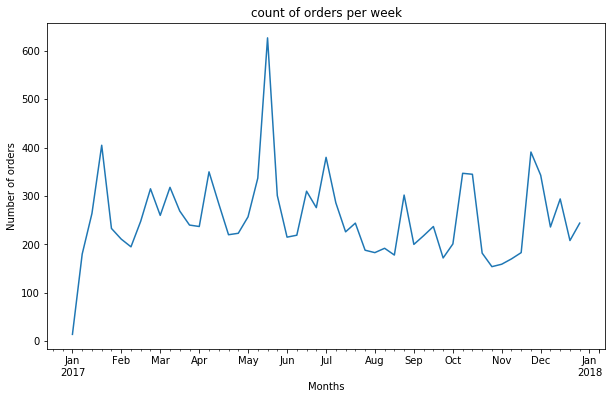

In [10]:
# plot
plt.figure(figsize=(10,6))
df.resample('W').size().plot()

plt.title('count of orders per week')
plt.xlabel('Months')
plt.ylabel('Number of orders')

**I consider "resample('W')" is the easiest method to plot the weekly value. But the line plot above was not straightforward. I suppose a bar plot with the x-axis represents week number will be a better option.**

In [11]:
def weekly_count_plt(df):
    weekly_count = pd.DataFrame() # create a new data frame
    weekly_count['count_of_orders'] = df.customer_id.resample('W').count() # count the customer_id per week
    weekly_count['weeks'] = list(range(1,54)) # generate sequential week number 
    
    plt.figure(figsize=(12,8))
    plt.title('count of orders per week')
    sns.barplot(x="weeks", y="count_of_orders", data=weekly_count)
    plt.show()

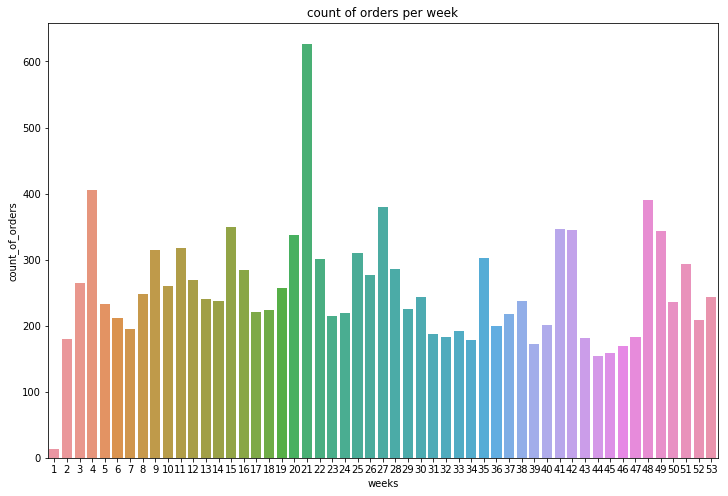

In [12]:
weekly_count_plt(df)

**I can't recognize the seasonality based on one year data. But we can identify the week 21 has the most orders immediately.**

### Question C
Compute the mean order value for gender 0 and for gender 1. Do you think the difference is significant?

In [13]:
def sig_test(g_0, g_1):
    from numpy import mean
    from numpy import std
    from scipy.stats import ttest_ind # t-test function
    
    print('---------------Compute the mean order value---------------')
    print('gender_0: mean=%.3f stdv=%.3f' % (mean(g_0), std(g_0)))
    print('gender_1: mean=%.3f stdv=%.3f' % (mean(g_1), std(g_1)))
          
    print('\n---------------T-Test---------------')
    print('Null hypothesis:No difference between the means')
    stat, p = ttest_ind(g_0, g_1)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    
    print('\n---------------Conclustion---------------')
    alpha = 0.05
    if p > alpha:
        print('Same distributions (fail to reject null hypothesis)')
    else:
        print('Different distributions (reject null hypothesis)')
        print('The means are different, corresponding confidence level is 95%.')

In [14]:
sig_test(df[df.gender == 0].value,df[df.gender == 1].value)

---------------Compute the mean order value---------------
gender_0: mean=363.890 stdv=396.504
gender_1: mean=350.708 stdv=377.477

---------------T-Test---------------
Null hypothesis:No difference between the means
Statistics=1.976, p=0.048

---------------Conclustion---------------
Different distributions (reject null hypothesis)
The means are different, corresponding confidence level is 95%.


**First of all, I assumed the values generated by gender0 and gender1 are independent. In this case, the assumption is that the means of gender0 order values and gender1 order values are equal. The t-test reveals that the null hypothesis is rejected and the difference is significant**

### Question D
Assuming a single gender prediction was made for each customer, generate a confusion matrix for predicted gender. Do not use a library function to do this. What does the confusion matrix tell you about the quality of the predictions?

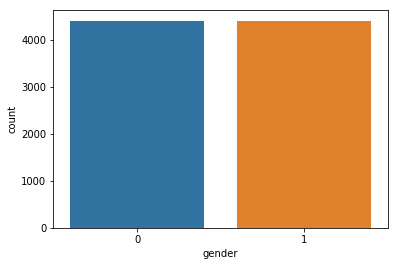

In [15]:
sns.countplot('gender', data=assembled_df)

**First of all, we can see the gender is balanced. Therefore, no need to consider imbalance issues.**

In [16]:
def plot_cnf_matrix (orig, pred):
    print('In this case, I assume that "predict gender 1 as 1" means true positiove\n')
    
    print("--------------------Confusion Matrix --------------------------")

    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(len(orig.values)):
        if orig.values[i]==1 and pred.values[i]==1:
            tp +=1
        if orig.values[i]==1 and pred.values[i]==0:
            fn +=1
        if orig.values[i]==0 and pred.values[i]==0:
            tn +=1
        if orig.values[i]==0 and pred.values[i]==1:
            fp +=1
            
    print("TP",tp) 
    print('TP: no. of gender 1 which are predicted gender 1')
    print("\nTN",tn) 
    print('TN: no. of gender 0 which are predited gender 0')
    print("\nFP",fp) 
    print('FP: no. of gender 0 which are predicted gender 1')
    print("\nFN",fn) 
    print('FN: no. of gender 1 which are predicted gender 0')

    
    print("\n--------------------Plot Confusion Matrix --------------------------")
    w, h = 2, 2;
    cnf_matrix = [[0 for x in range(w)] for y in range(h)] #Creates a 2 * 2 list
    cnf_matrix[0][0] = tn
    cnf_matrix[0][1] = fp
    cnf_matrix[1][0] = fn
    cnf_matrix[1][1] = tp
    
    fig= plt.figure(figsize=(6,3))
    sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,fmt='d',linewidths=0.5) # plot
    plt.title("Confusion_Matrix")
    plt.xlabel("Predicted_Class")
    plt.ylabel("Real_Class")
    plt.show()
    
    print("\n--------------------Classification Report --------------------------")
    print("the accuracy for this prediction is:", round((tp+tn)/(tp+tn+fp+fn),4))
    print("the precision for this prediction is :", round(tp/(tp+fp),4))
    print("the recall for this prediction is :", round(tp/(tp+fn),4))
    print("the f1 score for this prediction is:", round(2*tp/(2*tp+fp+fn),4))

In this case, I assume that "predict gender 1 as 1" means true positiove

--------------------Confusion Matrix --------------------------
TP 5249
TP: no. of gender 1 which are predicted gender 1

TN 3349
TN: no. of gender 0 which are predited gender 0

FP 3410
FP: no. of gender 0 which are predicted gender 1

FN 1463
FN: no. of gender 1 which are predicted gender 0

--------------------Plot Confusion Matrix --------------------------


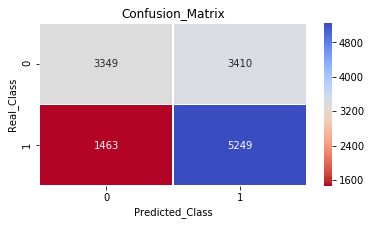


--------------------Classification Report --------------------------
the accuracy for this prediction is: 0.6383
the precision for this prediction is : 0.6062
the recall for this prediction is : 0.782
the f1 score for this prediction is: 0.683


In [17]:
plot_cnf_matrix(df.gender, df.predicted_gender) 

**In this case, I assume that "predict gender 1 as 1" means true positiove. Since it is not an imbalance classification problem, we can consider the accuracy, and it is 0.6383 which means our prediction is approx. 64% accurate. And the recall is higher means more gender 1 can be predict corrently. For further study, I suppose consider cost-sensitive classification will be helpful since we have the real finicial values.**

### Question E
Describe one of your favorite tools or techniques and give a small example of how it's helped you solve a problem. Limit your answer to one paragraph.
